# Фреймворк PyTorch для разработки искусственных нейронных сетей
# Урок 5. Рекурентные сети для обработки последовательностей

# <font color='red'>Практическое задание</font>

- Обучить GRU, LSTM для предсказания временного ряда на примере https://www.kaggle.com/c/favorita-grocery-sales-forecasting (для каждого типа продуктов)

Выполнил ___Соковнин ИЛ___

## Набор данных и определение проблемы

In [ ]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
import os, sys

PATH_DATA = '.\\data\\'
print(PATH_DATA)

.\data\


In [ ]:
%%time

train = pd.read_csv(PATH_DATA + "train.csv", sep=",")
print(train.shape)
# train = train.set_index('id')
train.head(3)

In [ ]:
train.info()

In [3]:
# функция для оптимизации использования памяти
def reduce_memory(df): 
    """Снижает размерности строк"""

    float_cols = df.select_dtypes(include=['float']).columns
    int_cols = df.select_dtypes(include=['int64']).columns
    
    df[float_cols] = df[float_cols].astype('float32')
    df[int_cols] = df[int_cols].astype('int32')
    
    return df

In [4]:
reduce_memory(train)
train.info()

In [ ]:
train_dt = train[['date', 'store_nbr', 'unit_sales']]
train_dt.info()
# train_dt.info(memory_usage='deep')
train_dt.head(3)

In [ ]:
%%time

train_dt.to_csv(PATH_DATA + 'train_dt.csv', index=False) 

In [ ]:
# del (train_dt)
# del(train)

# Освобождаем память
import gc
gc.collect()
gc.collect() # два раза подряд, для надёжности

In [2]:
%%time

train_dt = pd.read_csv(PATH_DATA + "train_dt.csv", sep=",")
print(train_dt.shape)
train_dt.info()
train_dt.head(3)

(125497040, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   date        object 
 1   store_nbr   int64  
 2   unit_sales  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.8+ GB
Wall time: 33.2 s


,date,store_nbr,unit_sales
0,2013-01-01,25,7.0
1,2013-01-01,25,1.0
2,2013-01-01,25,2.0


### Data processing
Subseting, join and aggregating data

In [6]:
stores = pd.read_csv(PATH_DATA + "stores.csv") 

In [9]:
%%time

t=train_dt.groupby(['store_nbr','date'], as_index=False).agg({"unit_sales": "sum"})
train = pd.merge(t, stores, how='left', on=['store_nbr'])
mask=train['state']=='Pichincha'
train=train.loc[mask]
train=train.groupby(['date'], as_index=False).agg({"unit_sales": "sum"})

Wall time: 125 ms


### Sales for Pichincha state (train data)

In [23]:
print(train.shape)
train.info()
train.tail(12)

(1679, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1679 entries, 0 to 1678
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1679 non-null   object 
 1   unit_sales  1679 non-null   float32
dtypes: float32(1), object(1)
memory usage: 32.8+ KB


,date,unit_sales
1667,2017-08-04,425713.15625
1668,2017-08-05,500614.56250
1669,2017-08-06,547592.12500
1670,2017-08-07,396073.43750
1671,2017-08-08,347288.25000
1672,2017-08-09,367813.87500
1673,2017-08-10,315940.31250
1674,2017-08-11,406504.40625
1675,2017-08-12,389945.59375
1676,2017-08-13,438714.53125


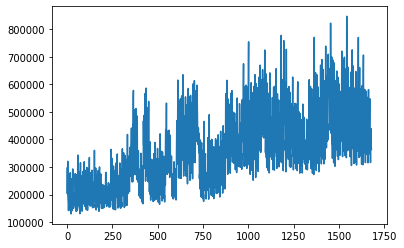

In [24]:
import matplotlib.pyplot as plt

plt.plot(train['unit_sales'])
plt.show()

There is a trend over time especially for the 2015 year, by 2015 and 2016 the slope gets lower and loses trend. It’s easy to recognize how the sales increasing over the last quarters.

In [25]:
# Сохраняем результат в файл
train.to_csv(PATH_DATA + 'train_data.csv', index=False) 

# 
### Задача состоит в том, чтобы предсказать продажи, k дней, исходя из первых n дней.

# 

# Решение - 1

При выполниении Д/З использовалась статья:<br>
Прогнозирование временных рядов с LSTM в Python - https://pythobyte.com/time-series-prediction-using-lstm-with-pytorch-in-python-521ce3ed/

### Загрузка подготовленных данных

In [36]:
data_df = pd.read_csv(PATH_DATA + "train_data.csv", sep=",")
print(data_df.shape)
data_df.info()
data_df.head(3)

(1679, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 0 to 1678
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1679 non-null   object 
 1   unit_sales  1679 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.4+ KB


,date,unit_sales
0,2013-01-02,295729.00
1,2013-01-03,203589.56
2,2013-01-04,203090.77


Задача состоит в том, чтобы предсказать продажи, k дней, исходя из первых n дней.

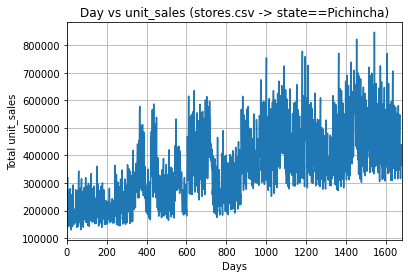

In [56]:
plt.title('Day vs unit_sales (stores.csv -> state==''Pichincha'')')
plt.ylabel('Total unit_sales')
plt.xlabel('Days')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(data_df['unit_sales'])

# Период: [2013-01-02, 2017-08-15]
# stores.csv-> 'state'=='Pichincha'

Вывод показывает, что со временем среднее количество продаж, увеличилось. Количество продаж в течение года, колеблется.

In [38]:
data_df['date'].head(1), data_df['date'].tail(1)

(0    2013-01-02
 Name: date, dtype: object,
 1678    2017-08-15
 Name: date, dtype: object)

In [39]:
data_df['unit_sales'].head(1),

(0    295729.0
 Name: unit_sales, dtype: float64,)

In [40]:
data_df.shape

(1679, 2)

In [41]:
data_df.columns

Index(['date', 'unit_sales'], dtype='object')

In [45]:
all_data = data_df['unit_sales'].values.astype(float)
print(len(all_data))
print(all_data)

1679
[295729.   203589.56 203090.77 ... 438714.53 377126.44 363382.6 ]


Далее мы разделим наш набор данных на обучающие и тестовые наборы. Алгоритм LSTM будет обучаться на обучающем наборе. Затем модель будет использоваться для составления прогнозов на тестовом наборе. Прогнозы будут сравниваться с фактическими значениями в тестовом наборе для оценки производительности обученной модели.

Первые 1179 записи будут использоваться для обучения модели, а последние 500 записей будут использоваться в качестве тестового набора. Следующий сценарий делит данные на обучающие и тестовые наборы.

#### Рзделил на train и test

In [46]:
test_data_size = 500

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]
print(len(train_data))
print(len(test_data))

1179
500


In [47]:
print(test_data)

[463464.44 662771.7  777635.6  432228.84 379148.5  408562.4  315344.3
 379869.22 525681.7  615886.7  361546.75 346025.97 365172.22 286234.47
 360473.7  485494.7  758259.1  733211.44 598701.94 574309.44 607436.5
 455092.47 566246.06 607025.3  360556.84 395416.12 367973.34 282274.84
 382455.6  588470.2  726919.8  576447.8  410174.12 436490.8  336640.72
 412194.03 583969.56 430678.62 407555.06 341508.56 396695.16 327221.53
 357535.9  505352.3  591819.7  392385.44 334703.4  376803.2  302710.72
 383055.9  492384.97 570427.56 371079.28 298319.9  343448.9  300307.38
 467630.97 434441.28 529404.56 405086.6  505375.12 438254.8  366658.94
 405301.44 548177.75 626164.5  398302.34 339516.12 379247.56 289516.16
 352132.06 456281.03 516675.97 373675.47 312857.   375318.47 323141.56
 418650.4  530918.4  448298.   384105.88 339030.47 362372.9  293393.9
 350778.4  470979.47 527770.75 374150.75 304862.3  340076.1  286655.62
 461741.25 572743.44 608798.56 466160.44 377913.47 410742.7  313421.22
 383011.3

#### Нормализуем данные с помощью скалера min/max с минимальными и максимальными значениями -1 и 1 соответственно.

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [49]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.46759538]
 [-0.76280631]
 [-0.76440442]
 [-0.51727788]
 [-0.38837831]]
[[ 0.17825205]
 [-0.29365632]
 [-0.39480955]
 [-0.28146193]
 [-0.34653452]]


##### Преобразуем наборы данных в тензоры для использования в модели PyTorch

In [50]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

#### Преобразование обучающих данных в последовательности и соответствующие метки.

In [51]:
train_window = 12

In [52]:
# Далее мы определим функцию с именем create_input_sequences . 
# Функция примет необработанные входные данные и вернет список кортежей.
# В каждом кортеже первый элемент будет содержать список из 12 пунктов, соответствующих продажам, за 12 дней,
# второй элемент кортежа будет содержать один пункт, т. е. количество продаж за 12+1-й день.

def create_inout_sequences(input_data, tw):
    """Функция принимает необработанные входные данные и возвращает список кортежей."""

    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
        
    return inout_seq

In [57]:
#Создаём последовательности
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [58]:
train_inout_seq[:5]

[(tensor([-0.4676, -0.7628, -0.7644, -0.5173, -0.3884, -0.8063, -0.8378, -0.8758,
          -0.9611, -0.8950, -0.6928, -0.5331]),
  tensor([-0.9013])),
 (tensor([-0.7628, -0.7644, -0.5173, -0.3884, -0.8063, -0.8378, -0.8758, -0.9611,
          -0.8950, -0.6928, -0.5331, -0.9013]),
  tensor([-0.9053])),
 (tensor([-0.7644, -0.5173, -0.3884, -0.8063, -0.8378, -0.8758, -0.9611, -0.8950,
          -0.6928, -0.5331, -0.9013, -0.9053]),
  tensor([-0.8320])),
 (tensor([-0.5173, -0.3884, -0.8063, -0.8378, -0.8758, -0.9611, -0.8950, -0.6928,
          -0.5331, -0.9013, -0.9053, -0.8320]),
  tensor([-0.9536])),
 (tensor([-0.3884, -0.8063, -0.8378, -0.8758, -0.9611, -0.8950, -0.6928, -0.5331,
          -0.9013, -0.9053, -0.8320, -0.9536]),
  tensor([-0.8745]))]

# LSTM

- __input_size__ : Соответствует количеству объектов во входных данных. Хотя длина нашей последовательности равна 12, для каждого дня у нас есть только 1 значение, то есть общее количество выручки, поэтому входной размер будет равен 1.
- __hidden_layer_size__ : Определяет количество скрытых слоев вместе с количеством нейронов в каждом слое. У нас будет один слой из 100 нейронов.
- __output_size__ : Количество элементов в выводе, так как мы хотим предсказать количество выручки на 1 день в будущем, размер вывода будет равен 1.

In [60]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [61]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [62]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


#### Обучение модели

Мы будем тренировать нашу модель в течение 300 эпох. Потери будут печататься через каждые 25 эпох.

In [99]:
epochs = 300

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


epoch:   1 loss: 0.01400300
epoch:  26 loss: 0.02697833
epoch:  51 loss: 0.01458593
epoch:  76 loss: 0.01115733
epoch: 101 loss: 0.00395531
epoch: 126 loss: 0.00441030
epoch: 151 loss: 0.00000258
epoch: 176 loss: 0.00243663
epoch: 201 loss: 0.00056983
epoch: 226 loss: 0.00014471
epoch: 251 loss: 0.00329403
epoch: 276 loss: 0.00000148
epoch: 299 loss: 0.0005294156


### Прогнозы

__Отфильтруем последние 10 значений из обучающего набора:__

In [100]:
fut_pred = 300

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.3236887753009796, -0.25877830386161804, -0.4524434804916382, -0.20583787560462952, -0.34753096103668213, -0.3208041191101074, 0.007369729224592447, 0.17825205624103546, -0.2936563193798065, -0.3948095440864563, -0.2814619243144989, -0.34653452038764954]


### Составление прогнозов

In [101]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())


In [102]:
test_inputs[fut_pred:]

[0.08698885142803192,
 0.3161541819572449,
 0.2977752685546875,
 0.15500690042972565,
 0.15066291391849518,
 0.07353302836418152,
 0.030370503664016724,
 0.06411997973918915,
 0.2871330976486206,
 0.33945566415786743,
 0.16767989099025726,
 0.1467825025320053]

### Преобразовать нормализованные прогнозные значения в фактические прогнозные значения. 

In [103]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[404058.11764047]
 [542398.9875933 ]
 [468210.59817248]
 [377573.35956626]
 [380596.39515483]
 [386168.75301129]
 [311055.08434328]
 [382434.19634088]
 [508278.56423947]
 [483710.74173009]
 [375164.1072417 ]
 [376226.09386062]
 [360450.07990559]
 [304520.40314166]
 [380576.20112176]
 [493397.20827097]
 [550540.55944484]
 [405321.8422777 ]
 [383533.4316956 ]
 [428962.67634893]
 [335536.48457663]
 [399944.19499045]
 [526771.00120265]
 [589467.77193204]
 [406229.19943681]
 [361537.19046892]
 [399025.47345552]
 [322861.40346025]
 [380910.66305041]
 [500795.06113857]
 [555451.77433236]
 [367159.12183955]
 [338324.7680189 ]
 [406158.99470875]
 [345566.15666251]
 [404060.98722094]
 [563571.02205706]
 [594099.80501   ]
 [402292.22339714]
 [358375.64762589]
 [401031.89621297]
 [313768.11687466]
 [380254.25465671]
 [512284.2753355 ]
 [530520.98942573]
 [361432.26707278]
 [319925.22267767]
 [369415.77480457]
 [296195.79205348]
 [357677.35824007]
 [505195.23025413]
 [551497.35291775]
 [370975.808

In [104]:
x = np.arange(1378, 1678, 1)
print(x)

[1378 1379 1380 1381 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391
 1392 1393 1394 1395 1396 1397 1398 1399 1400 1401 1402 1403 1404 1405
 1406 1407 1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419
 1420 1421 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433
 1434 1435 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447
 1448 1449 1450 1451 1452 1453 1454 1455 1456 1457 1458 1459 1460 1461
 1462 1463 1464 1465 1466 1467 1468 1469 1470 1471 1472 1473 1474 1475
 1476 1477 1478 1479 1480 1481 1482 1483 1484 1485 1486 1487 1488 1489
 1490 1491 1492 1493 1494 1495 1496 1497 1498 1499 1500 1501 1502 1503
 1504 1505 1506 1507 1508 1509 1510 1511 1512 1513 1514 1515 1516 1517
 1518 1519 1520 1521 1522 1523 1524 1525 1526 1527 1528 1529 1530 1531
 1532 1533 1534 1535 1536 1537 1538 1539 1540 1541 1542 1543 1544 1545
 1546 1547 1548 1549 1550 1551 1552 1553 1554 1555 1556 1557 1558 1559
 1560 1561 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571 1572 1573
 1574 

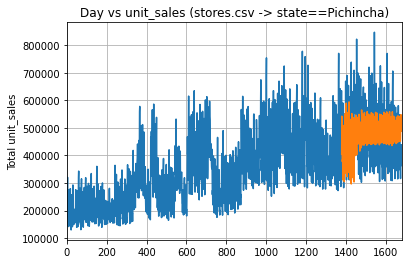

In [105]:
plt.title('Day vs unit_sales (stores.csv -> state==''Pichincha'')')
plt.ylabel('Total unit_sales')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data_df['unit_sales'])
plt.plot(x, actual_predictions)
plt.show()

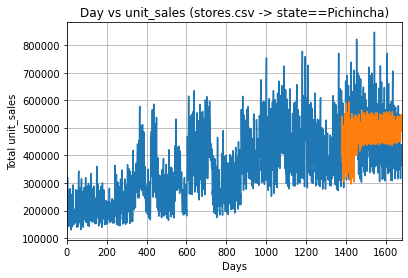

In [106]:
plt.title('Day vs unit_sales (stores.csv -> state==''Pichincha'')')
plt.ylabel('Total unit_sales')
plt.xlabel('Days')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(data_df['unit_sales'])
plt.plot(x,actual_predictions)
plt.show()

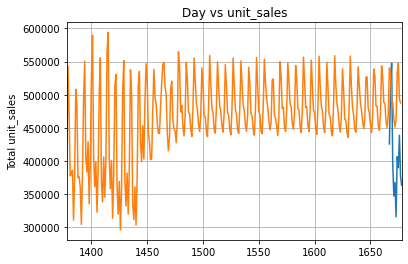

In [107]:
plt.title('Day vs unit_sales')
plt.ylabel('Total unit_sales')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(data_df['unit_sales'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()

Прогнозы не очень точны, но алгоритм смог уловить тенденцию

### GRU (меняем LSTM на GRU как на лекции)

In [108]:
class GRU(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.gru = nn.GRU(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        gru_out, self.hidden_cell = self.gru(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(gru_out.view(len(input_seq), -1))
        return predictions[-1]

In [109]:
model = GRU()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [110]:
print(model)

GRU(
  (gru): GRU(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [ ]:
epochs = 10

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

# Решение - 2 

In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### Загрузка подготовленных данных

In [5]:
train = pd.read_csv(PATH_DATA + "train_data.csv", sep=",")
print(train.shape)
train.info()
train.head(3)

(1679, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 0 to 1678
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1679 non-null   object 
 1   unit_sales  1679 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.4+ KB


,date,unit_sales
0,2013-01-02,295729.00
1,2013-01-03,203589.56
2,2013-01-04,203090.77


### Разделение выборки для обучающих и тестовых данных

In [6]:
train_size = int(len(train) * 0.75)
test_size = len(train) - train_size

print(train_size,test_size, len(train))

1259 420 1679


In [7]:
train1= train[0:train_size]
test =  train[train_size:len(train)]
print(len(train1), len(test))

1259 420


In [8]:
train1=train1.set_index("date")
test=test.set_index("date")
train=train.set_index("date")
train1=train1.values
test=test.values
train=train.values

Determine the number of previous time steps to use as input variables to predict the next time period. In this case (look_back) determinated to 1

In [9]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [11]:
# import numpy

look_back = 1
trainX, trainY = create_dataset(train1, look_back)
testX, testY = create_dataset(test, look_back)

In [19]:
trainX.shape, trainY.shape

((1257, 1), (1257,))

Multilayer Perceptron model
A simple network with 1 input (look_back) , 1 hidden layer with 8 neurons and one (1) output layer.

In [14]:
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
629/629 - 5s - loss: 14533445632.0000 - 5s/epoch - 7ms/step
Epoch 2/200
629/629 - 2s - loss: 7524797440.0000 - 2s/epoch - 2ms/step
Epoch 3/200
629/629 - 1s - loss: 7560857088.0000 - 1s/epoch - 2ms/step
Epoch 4/200
629/629 - 1s - loss: 7531424256.0000 - 1s/epoch - 2ms/step
Epoch 5/200
629/629 - 2s - loss: 7566036480.0000 - 2s/epoch - 2ms/step
Epoch 6/200
629/629 - 2s - loss: 7550424576.0000 - 2s/epoch - 2ms/step
Epoch 7/200
629/629 - 2s - loss: 7579824128.0000 - 2s/epoch - 2ms/step
Epoch 8/200
629/629 - 2s - loss: 7572335616.0000 - 2s/epoch - 2ms/step
Epoch 9/200
629/629 - 1s - loss: 7573846016.0000 - 1s/epoch - 2ms/step
Epoch 10/200
629/629 - 1s - loss: 7536196608.0000 - 1s/epoch - 2ms/step
Epoch 11/200
629/629 - 1s - loss: 7586246144.0000 - 1s/epoch - 2ms/step
Epoch 12/200
629/629 - 1s - loss: 7436213248.0000 - 1s/epoch - 2ms/step
Epoch 13/200
629/629 - 1s - loss: 7567697408.0000 - 1s/epoch - 2ms/step
Epoch 14/200
629/629 - 1s - loss: 7576020992.0000 - 1s/epoch - 2ms/step


Epoch 115/200
629/629 - 2s - loss: 7565471744.0000 - 2s/epoch - 2ms/step
Epoch 116/200
629/629 - 2s - loss: 7562579456.0000 - 2s/epoch - 3ms/step
Epoch 117/200
629/629 - 2s - loss: 7551458304.0000 - 2s/epoch - 2ms/step
Epoch 118/200
629/629 - 2s - loss: 7580190720.0000 - 2s/epoch - 3ms/step
Epoch 119/200
629/629 - 2s - loss: 7553456640.0000 - 2s/epoch - 2ms/step
Epoch 120/200
629/629 - 2s - loss: 7548702208.0000 - 2s/epoch - 3ms/step
Epoch 121/200
629/629 - 1s - loss: 7530082816.0000 - 1s/epoch - 2ms/step
Epoch 122/200
629/629 - 2s - loss: 7566064128.0000 - 2s/epoch - 2ms/step
Epoch 123/200
629/629 - 2s - loss: 7561574400.0000 - 2s/epoch - 2ms/step
Epoch 124/200
629/629 - 2s - loss: 7510500352.0000 - 2s/epoch - 2ms/step
Epoch 125/200
629/629 - 2s - loss: 7554005504.0000 - 2s/epoch - 2ms/step
Epoch 126/200
629/629 - 2s - loss: 7535081472.0000 - 2s/epoch - 3ms/step
Epoch 127/200
629/629 - 2s - loss: 7564379648.0000 - 2s/epoch - 2ms/step
Epoch 128/200
629/629 - 2s - loss: 7529616384.0000 

### 

In [16]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 7544227328.00 MSE (86857.51 RMSE)
Test Score: 13193974784.00 MSE (114865.03 RMSE)


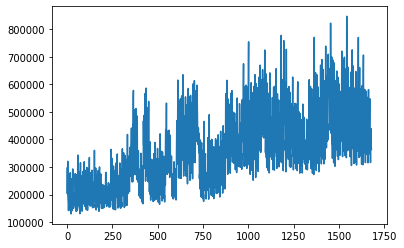

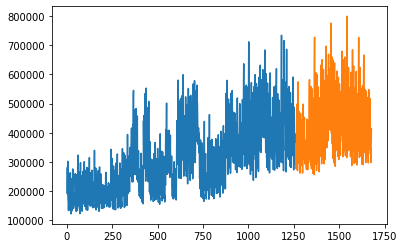

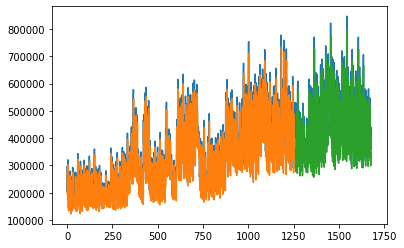

In [17]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 
trainPredictPlot = numpy.empty_like(train)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
testPredictPlot = numpy.empty_like(train)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(train)-1, :] = testPredict
 
plt.plot(train)
plt.show()
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
plt.plot(train)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


The average error in the training data is 86.857 units and the averrage in the test data is 114.865 units sold per day

**сеть:  LSTM слои+Conv1D +Dense слой.**

In [ ]:
callbaсk = EarlyStopping(monitor='val_mae', patience=2)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences="True")) # <None, 3,32>
model.add(Conv1D(64, 3, activation="linear")) #(None,3,64)
#model.add(Conv1D(64, 1, activation="linear"))
model.add(Flatten())                          # (None, 3*64)
model.add(Dense(3, activation="linear"))      # (None,3)

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Все параметры класса RNN<br>
Приведём список всех параметров класса RNN в фреймворке PyTorch:<br>
nn.RNN<br>
__… (input_size, hidden_size, num_layers=1, nonlinearity='tanh', bias=True, … batch_first=False, dropout=0, bidirectional=False) [doc]__

Отметим не упомянутый ранее параметр dropout. По умолчанию он равен нулю. При ненулевом значении, после каждого слоя (num_layers > 1), кроме последнего, вставляется слой dropout, который с вероятностью dropout случайно "отключает" (делает нулевыми) часть элементов тензоров на выходах каждой ячейке.

Установка параметра bias в значение False ликвидирует вектор смещения после перемножения матриц.

https://qudata.com/ml/ru/NN_RNN_Torch.html - ML: Рекуррентные сети на PyTorch

https://www.kaggle.com/code/byronvinu/lstm-network-for-regression/notebook              